In [1]:
import numpy as np
import pandas as pd
# import lightgbm as lgb
import datetime
import math
import gc
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import xgboost as xgb
from sklearn import svm
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
import sklearn.metrics
from sklearn.ensemble import RandomForestClassifier

In [2]:
def roccurve(y,scores):
    fpr=np.zeros(len(y))
    tpr=np.zeros(len(y))
#    fpr[len(y)-1]=1
#    tpr[len(y)-1]=1
    t=sorted(zip(scores,y),reverse=True)
    y=np.array([t[i][1] for i in range(len(t))])
    scores=np.array([t[i][0] for i in range(len(t))])
    for i in range(len(y)):
        temp1=zip(scores[:i+1],y[:i+1])
        temp2=zip(scores[i+1:],y[i+1:])
        TP=sum(np.array([temp1[j][1] for j in range(len(temp1))]))
        FN=sum(np.array([temp2[j][1] for j in range(len(temp2))]))
        FP=len(temp1)-TP
        TN=len(temp2)-FN
        tpr[i]=TP/(sum(np.array([t[j][1] for j in range(len(t))]))).astype(float)
        fpr[i]=FP/(len(t)-sum(np.array([t[j][1] for j in range(len(t))]))).astype(float)
    x=np.append([0],list(fpr))
    y=np.append([0],list(tpr))
    x=list(x)
    y=list(y)
    print 'roc cal end...'
    plt.figure(figsize=(2,2))  
    plt.plot(x,y,"b--",linewidth=1)     
    plt.xlabel("Time(s)") 
    plt.ylabel("Volt")  
    plt.title("Line plot") 
    plt.show() 
    plt.savefig("line.jpg")
    return fpr, tpr

In [3]:
def aucarea(fpr, tpr):
    area=0
    a=[0,0]
    b=[0,0]
    for i in range(len(tpr)):
        b[0]=fpr[i]
        b[1]=tpr[i]
        if b[1]==a[1] and b[0]>a[0]:
            area+=b[1]*(b[0]-a[0])
        a[0]=b[0]
        a[1]=b[1]
    return area

def cal_auc(y_pred_prob,y):
    fpr, tpr, thresholds = sklearn.metrics.roc_curve(y, y_pred_prob, pos_label=1)
    print sklearn.metrics.auc(fpr, tpr)

In [5]:
print 'loading data...'
concat=np.load('../inputs/concat4Kaggle.npy')

np.random.shuffle(concat)

print 'get training data...'
concat_experiment=concat[:concat.shape[0]/50,:]

concat_experiment_refine=np.concatenate((concat_experiment[:,:8],concat_experiment[:,8+1:]),axis=1) #del original index 8 column
concat_experiment_refine=np.concatenate((concat_experiment_refine[:,:32],concat_experiment_refine[:,32+1:]),axis=1) #del original index 33 col
# concat_experiment_refine=np.concatenate((concat_experiment_refine[:,:5],concat_experiment_refine[:,7:21],concat_experiment_refine[:,23:24],concat_experiment_refine[:,25:]),axis=1)
#22,5,21,6,24


loading data...
get training data...


In [6]:
def aveVar(aucs):
    aucs=np.array(aucs)
    average=np.mean(aucs)
    var=np.var(aucs)
    print 'average auc:{}, var :{}'.format(average,var)
    return average
    
    
def modelTrain_RF(model,X_train,y_train,X_test):
    
    model.fit(X_train,y_train)
#     model.fit(X_train,y_train)
    RF_score=model.predict_proba(X_test)
    return RF_score[:,1]


def kFoldCV(model,K,concat_experiment_refine):
    start=0
    dataLen=concat_experiment_refine.shape[0]/K
    aucs=[]
    print '**************** new model RandomForest ***********************'
    for i in range(K):
        X_test_cv=concat_experiment_refine[start:(start+dataLen),:-1]
        y_test_cv=concat_experiment_refine[start:(start+dataLen),-1]
        y_test_cv=y_test_cv.reshape([y_test_cv.shape[0],])

        train_idx=np.array(range(0,start)+range(start+dataLen,concat_experiment_refine.shape[0]))
        X_train_cv=concat_experiment_refine[train_idx[:None],:-1]
        y_train_cv=concat_experiment_refine[train_idx[:,None],-1]
        y_train_cv=y_train_cv.reshape([y_train_cv.shape[0],])
        print 'X_train shape:{}, y_train_cv:{},X_test shape:{}, y_test shape:{}'.format(X_train_cv.shape,y_train_cv.shape,X_test_cv.shape,y_test_cv.shape)
        start+=dataLen

        y_pred=modelTrain_RF(model,X_train_cv,y_train_cv,X_test_cv)

#         model.fit(X_train_cv,y_train_cv,eval_metric='auc')
#         y_pred = model.predict(X_test_cv)
        auc=roc_auc_score(y_test_cv, y_pred)
#         accuracy=accuracy_score(y_test_cv, y_pred)
#         print "auccuracy is",accuracy
#         aucs.append(auc)
        print "auc is",auc
        aucs.append(auc)
    print aucs
    return aveVar(aucs)

In [7]:
RF=RandomForestClassifier(max_depth=70,n_estimators=20,min_samples_leaf=1, random_state=0)
            
print 'cross validation on RF...'
kFoldCV(RF,5,concat_experiment_refine)

cross validation on RF...
**************** new model RandomForest ***********************
X_train shape:(118039, 32), y_train_cv:(118039,),X_test shape:(29509, 32), y_test shape:(29509,)
auc is 0.681040336616
X_train shape:(118039, 32), y_train_cv:(118039,),X_test shape:(29509, 32), y_test shape:(29509,)
auc is 0.681727340852
X_train shape:(118039, 32), y_train_cv:(118039,),X_test shape:(29509, 32), y_test shape:(29509,)
auc is 0.675737892451
X_train shape:(118039, 32), y_train_cv:(118039,),X_test shape:(29509, 32), y_test shape:(29509,)
auc is 0.675731934595
X_train shape:(118039, 32), y_train_cv:(118039,),X_test shape:(29509, 32), y_test shape:(29509,)
auc is 0.682486012971
[0.68104033661583852, 0.68172734085225506, 0.67573789245083093, 0.67573193459476855, 0.68248601297112255]
average auc:0.679344703497, var :8.89622854325e-06


0.67934470349696308

In [8]:
print 'training RF for roc curve...'
trainLen=int(concat_experiment_refine.shape[0]*0.8)

concat_X_train,concat_X_test,concat_y_train,concat_y_test=concat_experiment_refine[:trainLen,:-1],concat_experiment_refine[trainLen:,:-1],concat_experiment_refine[:trainLen,-1],concat_experiment_refine[trainLen:,-1]

RF.fit(concat_X_train,concat_y_train)
RF_score=RF.predict_proba(
concat_X_test
)

y4plot=np.zeros([concat_y_test.shape[0],2])
i=0
for y in concat_y_test:
    if y==1:
        y4plot[i,1]=1
    else:
        y4plot[i,0]=1
    i+=1

cal_auc(RF_score[:,1],concat_y_test)

training RF for roc curve...
0.681880596576


plot roc curve...


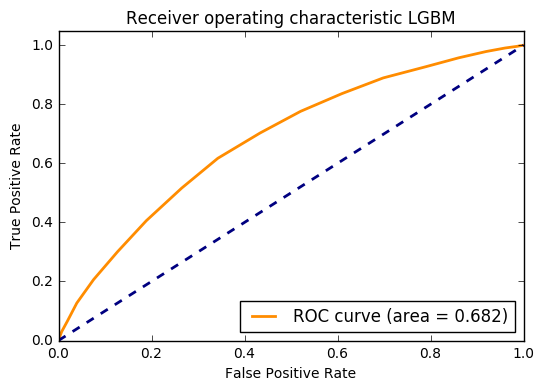

In [11]:
print 'plot roc curve...'
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes=2
for i in range(n_classes):
#     print i
    fpr[i], tpr[i], _ = roccurve(y4plot[:, i].astype(float),RF_score[:, i].astype(float))
    roc_auc[i] = aucarea(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roccurve(y4plot.ravel(), RF_score.ravel())
roc_auc["micro"] = aucarea(fpr["micro"], tpr["micro"])

# pkl.dump(fpr,open('fpr.pkl','w'))
# pkl.dump(tpr,open('tpr.pkl','w'))
# pkl.dump(roc_auc,open('roc_auc.pkl','w'))
plt.figure()
lw = 2
plt.plot(fpr[1], tpr[1], color='darkorange',
         lw=lw, label='ROC curve (area = %0.3f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic LGBM')
plt.legend(loc="lower right")
plt.show()
